<a href="https://colab.research.google.com/github/MTonyM/rcs/blob/master/get_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
peaks = [
         [r, c, cls], ...
]
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import square, dilation, erosion
LIMSEQ = [[2,3] ,[2,6], [3,4], [4,5], [6,7], [7,8], [9,10],  
          [10,11], [12,13], [13,14], [1,15], [15,17], 
          [1,16], [16,18], [9,12], [12,6], [9,3], [2, 17], [2, 18]]
CODESEQ = [2, 3, 9, 12, 6, 2, 18, 16, 15, 17, 2]


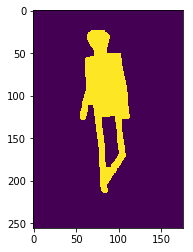

True

In [84]:
def _get_sparse_keypoint(r, c, k, h, w, R):
    r = int(r)
    c = int(c)
    k = int(k)
    indices, values = [], []
    for i in range(-R, R+1):
        for j in range(-R, R+1):
            distance = np.sqrt(float(i**2 + j**2))
            if r+i >= 0 and r+i < h and c+j>=0 and c+j <w:
                if distance < R:
                    indices.append([r+i, c+j, k])
                    values.append(1)
    return indices, values

def _get_mask_data_by_corr(corr, shape_human, radius):
    indices = []
    values = []
    h, w = shape_human
    mask = np.zeros((h ,w))
    # index should be 0-based.
    codeseq = [x - 1 for x in CODESEQ]
    for limb in LIMSEQ:
        p0, p1 = corr[limb[0]-1], corr[limb[1]-1]
        if np.all(p0==0) or np.all(p1==0):
            print(p0, p1, limb)
            if np.all(p0==0) and limb[0] - 1  in codeseq:
                codeseq.remove(limb[0] - 1)
            if np.all(p1==0) and limb[1] - 1 in codeseq:
                codeseq.remove(limb[1] - 1)
            continue
        c0, r0 = p0[:2][::-1]
        c1, r1 = p1[:2][::-1]
        # print(r0, c0, r1, c1)
        ind0, val0 = _get_sparse_keypoint(r0, c0, 0, h, w, radius)
        ind1, val1 = _get_sparse_keypoint(r1, c1, 0, h, w, radius)
        distance = np.sqrt((r0-r1)**2 + (c0-c1)**2)
        sampleN = int(distance / radius) * 100
        for i in range(1, sampleN ):
            r = int(r0 + (r1 - r0) * (i / sampleN))
            c = int(c0 + (c1 - c0) * (i / sampleN))
            ind, val = _get_sparse_keypoint(r, c, 0, h, w, radius)
            indices += ind
            values += val
        indices += ind0 + ind1
        values += val0 + val1

    indices = np.array(indices)
    ind_r, ind_c = np.split(indices[:, :2], 2, axis=-1)
    mask[ind_r, ind_c] = 1
    cv2.fillPoly(mask, np.int32([corr[codeseq][:, :2][:,::-1]]), 1, (1))
    mask = dilation(mask, square(5))
    mask = erosion(mask, square(5))
    return mask

def get_mask_by_peaks(peaks, radius=4):
    shape_human = peaks.shape[:2]
    raw_corr = np.stack(np.nonzero(peaks), axis=-1)
    corr = np.zeros((18, 2), dtype=np.int32)
    for i in range(raw_corr.shape[0]):
        cls = raw_corr[i, -1]
        corr[cls, :] = raw_corr[i, :2]
    mask = _get_mask_data_by_corr(corr, shape_human, radius)
    return mask

dataK_path = '/content/fashionWOMENTees_Tanksid0000796903_7additional.jpg.npy'
peaks = np.load(dataK_path)
mask = get_mask_by_peaks(peaks)
plt.imshow(mask)
plt.show()
cv2.imwrite('mask.png', mask*255)